# О проекте:

Название: Анализ приложения Procrastinate Pro+. 

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

**Цель проекта:** разобраться в причинах убытков компании и помочь ей выйти в плюс.

**Задачи проекта:**
1) Изучить, откуда приходят пользователи и какими устройствами они пользуются;
2) Изучить, сколько стоит привлечение пользователей из различных рекламных каналов;
3) Изучить, сколько денег приносит каждый клиент;
4) Изучить, когда расходы на привлечение клиента окупаются;
5) Изучить, какие факторы мешают привлечению клиентов.

Требуется описать найденные проблемы и ответить на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? 

**В выводах проекта требуется:**
- Выделить причины неэффективности привлечения пользователей;
- Сформировать рекомендации для отдела маркетинга для повышения эффективности.

**Описание данных:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
#импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math

In [2]:
#импортируем и сохраняем таблицы
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv')  # расходы
)

In [3]:
#получаем информацию о визитах
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
#регион, устройство и канал приведем к строковому типу
visits['Region'] = visits['Region'].astype(str)
visits['Device'] = visits['Device'].astype(str)
visits['Channel'] = visits['Channel'].astype(str)

In [5]:
#переименуем названия столбцов для корректного использования в формулах
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [6]:
#изучим уникальные значения в столбце region:
visits.region.value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

Пользователи представляют 4 страны: США (с самым большим рынком), Франция, Германия и Великобритания.

In [7]:
#изучим уникальные значения в столбце device:
visits.device.value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

Пользователи пользуются 4 видами устройств: Android, PC, Mac и Iphone.

In [8]:
#изучим уникальные значения в столбце channel:
visits.channel.value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

Пользователи привлекаются через 10 каналов. Органических пользователей больше всего.

In [9]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%Y.%m.%d %H:%M")
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%Y.%m.%d %H:%M")

In [10]:
#проверим дубликаты
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


Дубликатов нет. Данные готовы к использованию.

In [11]:
#получаем информацию о заказах
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [12]:
#переименуем названия столбцов для корректного использования в формулах
orders.columns = ['user_id', 'event_dt', 'revenue']

In [13]:
# преобразование данных о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y-%m-%d %H:%M:%S")

In [14]:
#проверим данные на наличие дубликатов
orders[orders.duplicated()]

,user_id,event_dt,revenue


Дубликатов нет. Данные готовы к использованию.

In [15]:
#получаем информацию о заказах
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [16]:
#переименуем названия столбцов для корректного использования в формулах
costs.columns = ['dt', 'channel', 'costs']

In [17]:
# преобразование данных о времени
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [18]:
#проверим данные на наличие дубликатов
costs[costs.duplicated()]

,dt,channel,costs


Дубликатов нет. Данные готовы к использованию.

**ВЫВОД:**  

Во всех трех таблицах нет пропущенных значений и дубликатов. Типы данных в столбцах с датами заменили на формат datetime. Теперь данные готовы к дальнейшему исследованию.

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**ВЫВОД:**  

Функции для расчета и анализа LTV, ROI, удержания и конверсии готовы к использованию.

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [22]:
# таблица для получения профилей пользователей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [23]:
# получаем профили пользователей (и смотрим на работу функции)
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [24]:
# определяем минимальную и максимальную дату привлечения пользователей.
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  # - является моментом анализа
horizon_days = 14  # горизонт анализа
print(' Минимальная дата анализа:', min_analysis_date, "\n", 'Момент анализа:',  observation_date, "\n", 'Горизонт анализа:',   horizon_days)

 Минимальная дата анализа: 2019-05-01 00:00:00 
 Момент анализа: 2019-10-27 00:00:00 
 Горизонт анализа: 14


Выясняем, из каких стран приходят посетители и какие страны дают больше всего платящих пользователей:

In [25]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='payer',ascending = False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


Выясняем, какими устройствами пользуются пользователи и с каких устройств чаще всего заходят платящие пользователи:

In [26]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='payer',ascending = False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Выясняем, по каким рекламным каналам шло привлечение пользователей и какие каналы приносят больше всего платящих пользователей:

In [27]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='payer',ascending = False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


**ВЫВОД**

На основании построенных таблиц видим следующие данные, позволяющие ответить на поставленные вопросы:

Посетители приходят из США, Германии, Великобритании и Франции, большую часть составляют пользователи из США. Больше всего процент платящих пользователей в США.

Пользователи пользуются Mac, iPhone, PC и Android. Чаще всего платящие пользователи заходят с iPhone, процент платящих с этих устройств лишь немногим меньше, чем с Mac, но количество платящих больше.

Привлечение пользователей шло по десяти каналам, из которых больше всего пользователей приносят FaceBoom и TipTop, а платящих пользователей приносят FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [28]:
display(costs['costs'].sum())

105497.30000000002

Общая сумма расходов на маркетинг - 105497.3. Выясним, как траты распределены по источникам и во времени, перед этим удалив окупающихся всегда органических пользователей.

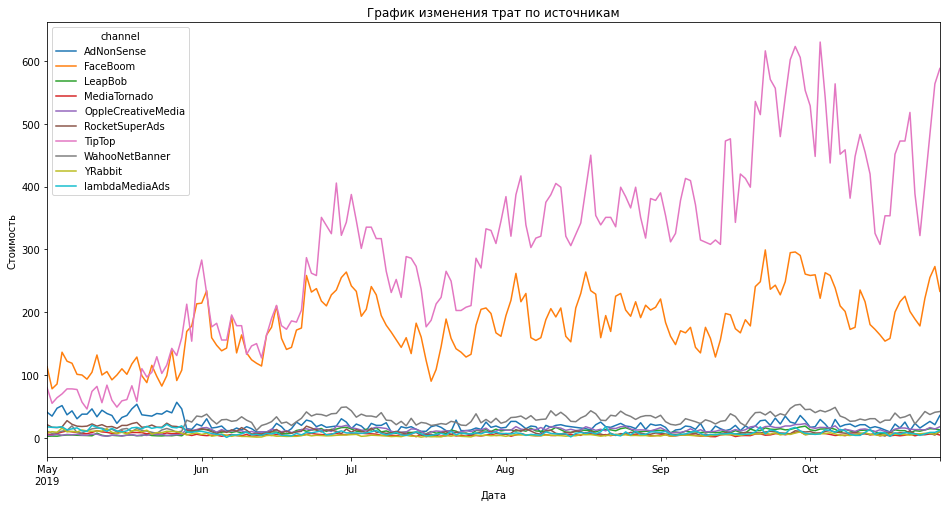

In [29]:
profiles = profiles.query('channel != "organic"')
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(figsize=(16,8))
plt.ylabel('Стоимость')
plt.xlabel('Дата')
plt.title('График изменения трат по источникам')
plt.show()

In [30]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Наибольшие траты идут на источники TipTop и FaceBoom. Наблюдаем увеличение затрат во времени. Далее узнаем, сколько стоило привлечение одного покупателя из каждого источника.

In [31]:
cac_by_channel = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac',ascending = False)
)

cac_by_channel

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Самые дорогие источники - TipTop (2.8 за пользователя), далее идет FaceBoom (1.11 за пользователя) и AdNonSense (1.00 за пользователя). Цены остальных каналов варьируются в пределах от 0.21 до 0.72. В целях дополнительной оценки можно построить график изменения САС по каналам во времени:

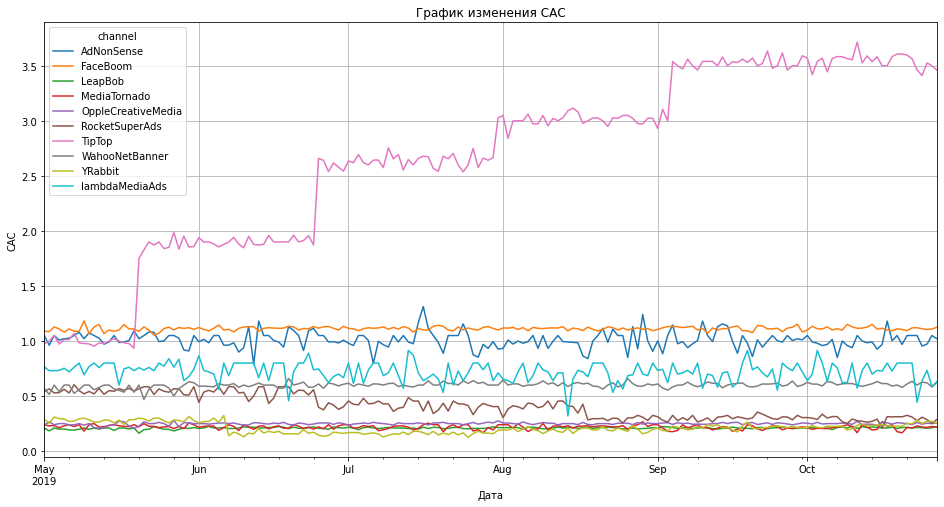

In [32]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(16, 8))
plt.ylabel('CAC')
plt.xlabel('Дата')
plt.title('График изменения САС')
plt.show()

**Вывод**

Посчитали, что на рекламу потрачено 105497.3, и что наибольшие траты идут на источники TipTop и FaceBoom. Более того, по последнему графику видно, что САС по TipTop увеличивается с течением времени почти на 0.5 каждый месяц. Посчитали также САС по каждому источнику, самые дорогие источники - TipTop (2.8 за пользователя), далее идет FaceBoom (1.11 за пользователя) и AdNonSense (1.00 за пользователя). Остальные каналы берут за пользователя от 0.21 до 0.72.

In [33]:
print('Средний CAC всего проекта -', profiles['acquisition_cost'].mean().round(2))

Средний CAC всего проекта - 1.13


# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей (то есть 14 дней).

In [34]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [35]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(16, 8))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Проанализируйте общую окупаемость рекламы

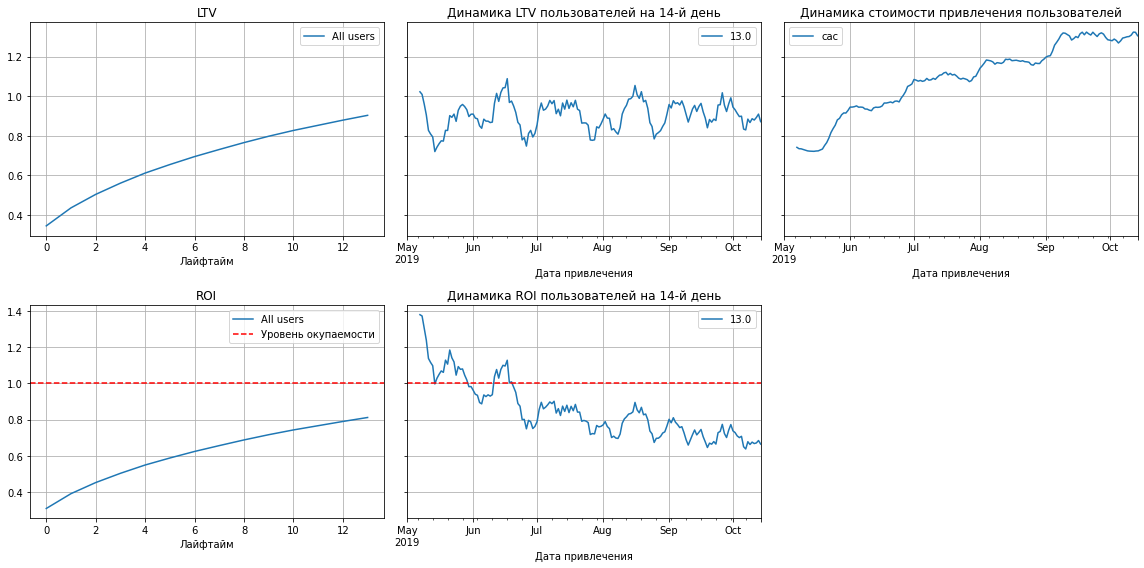

In [36]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Вывод по графикам:

1. Показатель LTV стабилен.
2. CAC нестабилен, стоимость привлечения клиента растёт.
3. Реклама не окупается.
4. ROI пользователей неумолимо падает. До середины июня показатель был выше уровня окупаемости, но затем пошел спад.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

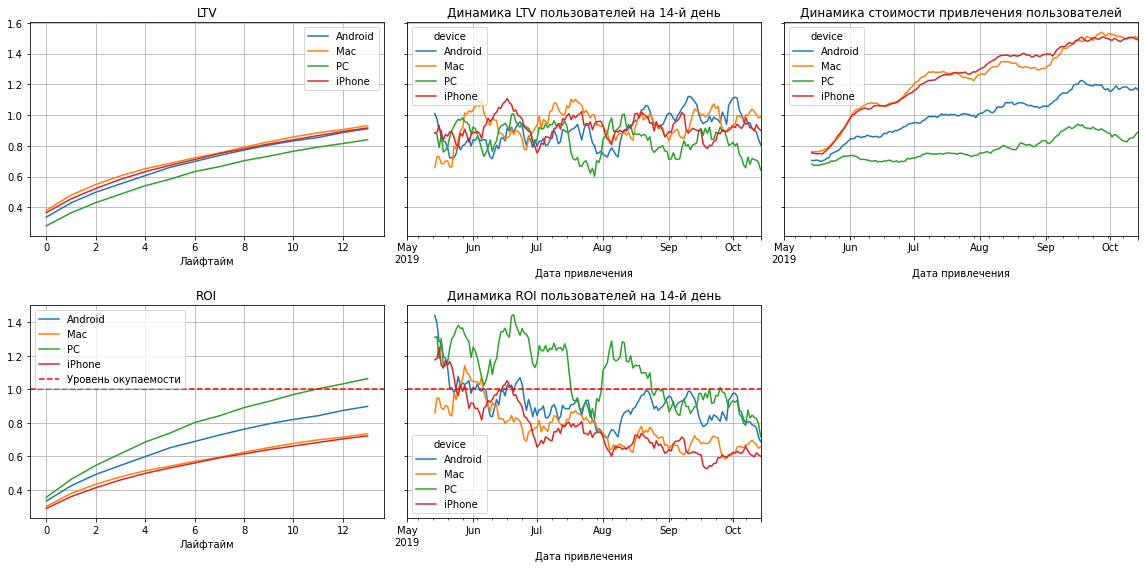

In [37]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод по графикам:

1. Показатель LTV на всех устройствах стабилен.
2. Динамика стоимости новых пользователей растёт.
3. Реклама не окупается на всех устройствах, кроме PC.
4. Динамика ROI на всех устройствах падает.

### Проанализируйте окупаемость рекламы с разбивкой по странам

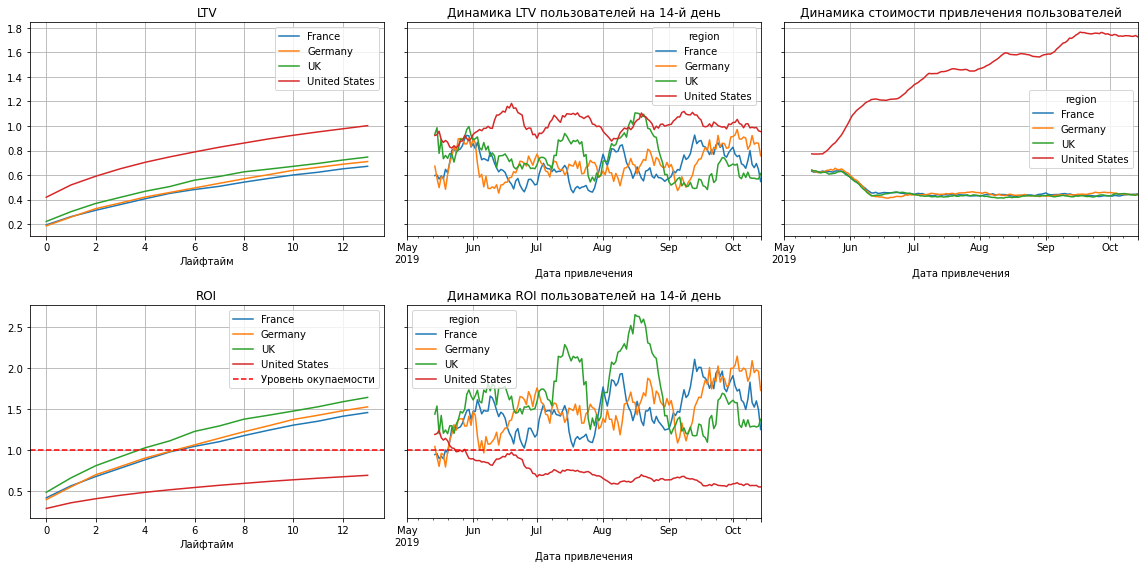

In [38]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод по графикам:

1. LTV во всех странах стабилен.
2. Стоимость привлечения пользователей из Америки - самая высокая и растет еще.
3. Реклама окупается во всех странах, но не в США, причем помним, что пользователи из США - это основная аудитория.
4. Видим, что окупаемость пользователей в США начала падать с середины июня 2019 года. 

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

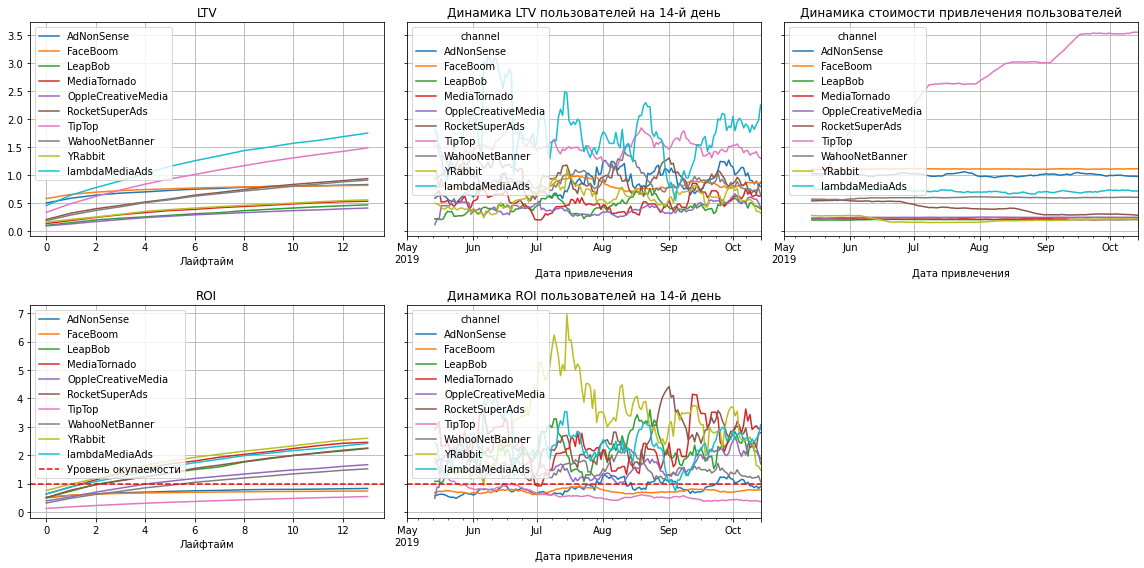

In [39]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод по графикам:

1. LTV стабилен во всех каналах привлечения.
2. Динамика стоимости пользователя показывает, что стоимость привлечения пользователей через TipTop намного превышает стоимость остальных каналов.
3. По графику ROI видим, что каналы TipTop, FaceBoom и AdNonSence не окупаются. 

Напрашивается вывод, что для привлечения пользователей из рекламного канала TipTop потрачено много средств, но пользователи от него совсем не окупаются. Впрочем, как и из каналов FaceBoom и AdNonSence. Теперь пришло время построить графики конверсии и удержания с разбивкой по устройствам, странам и рекламным каналам.

Для начала построим функцию визуализации конверсии:

In [40]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Теперь функцию визуализации удержания:

In [41]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Построим графики конверсии и удержания с разбивкой по устройствам:

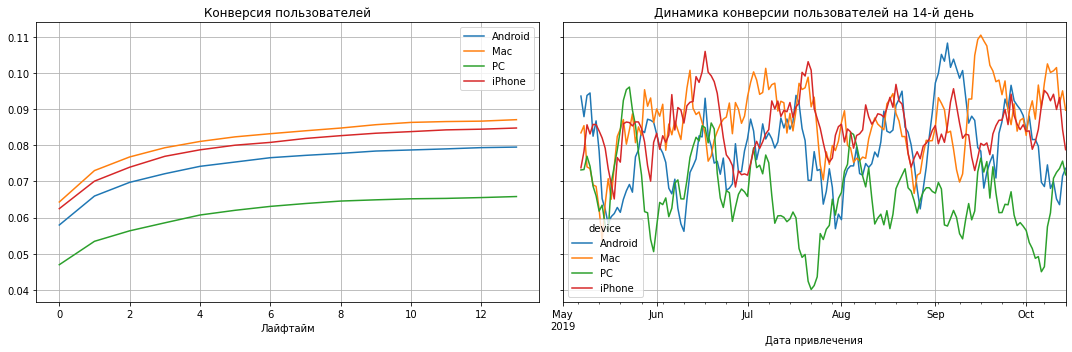

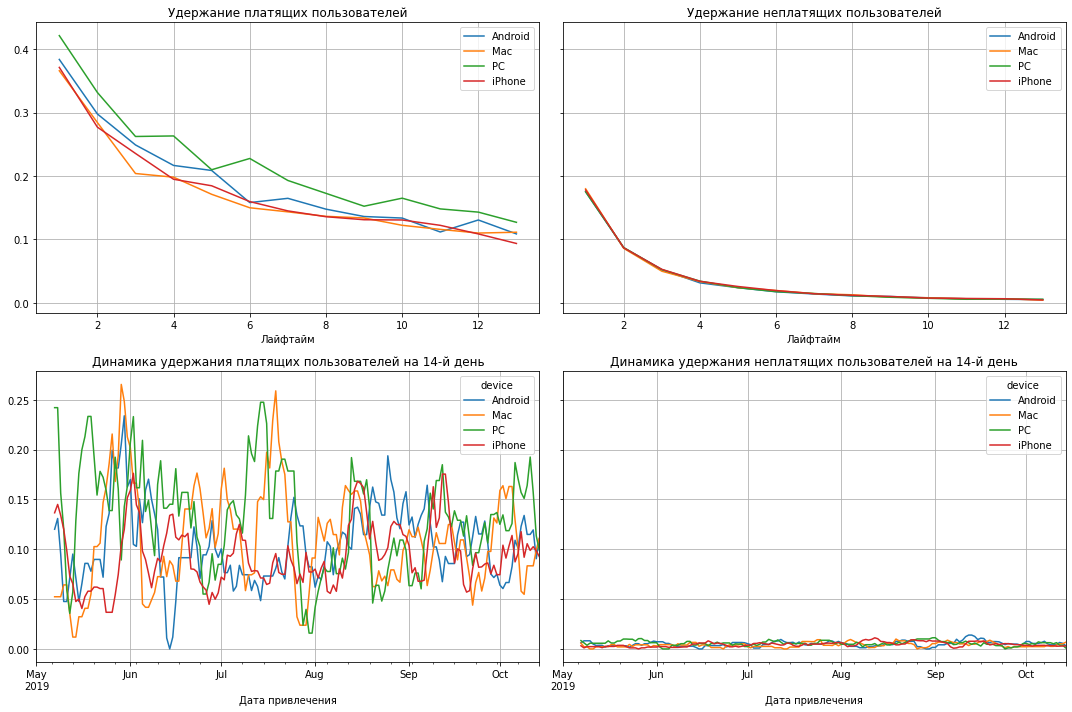

In [42]:
dimensions=['device']

# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Показатели конверсии стабильны, а по графикам удержания не похоже, что проблема в каком-то конкретном устройстве. Построим графики конверсии и удержания с разбивкой по странам:

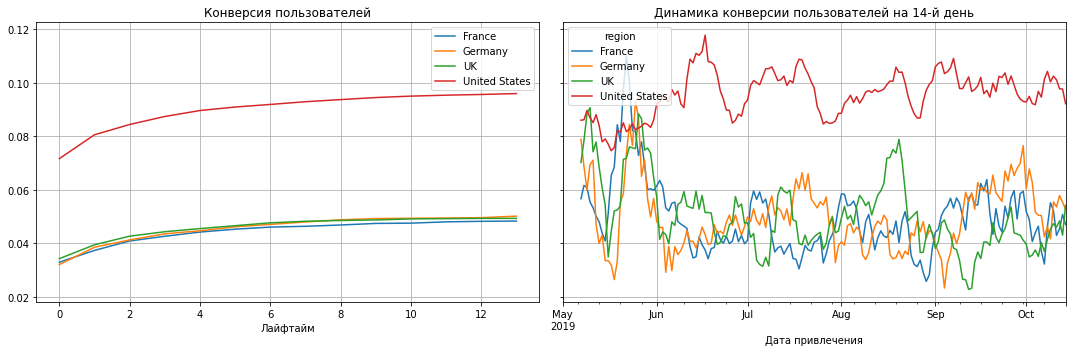

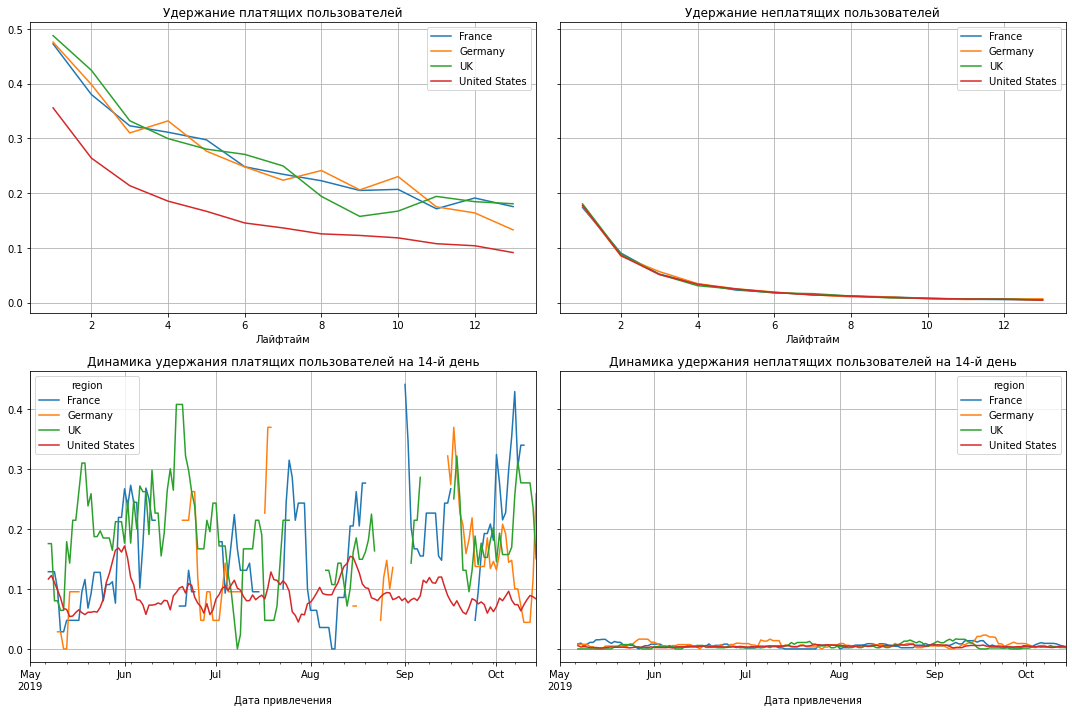

In [43]:
dimensions=['region']

# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия пользователей из Англии, Германии и Франции слабее, чем у пользователей из США, но стабильна. Тем не менее видим, что пользователи из США удерживаются плохо. Построим графики конверсии и удержания с разбивкой по по рекламным каналам:

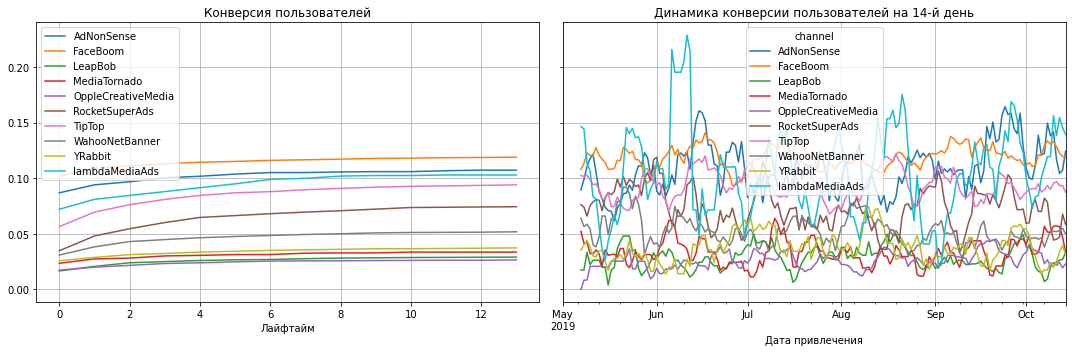

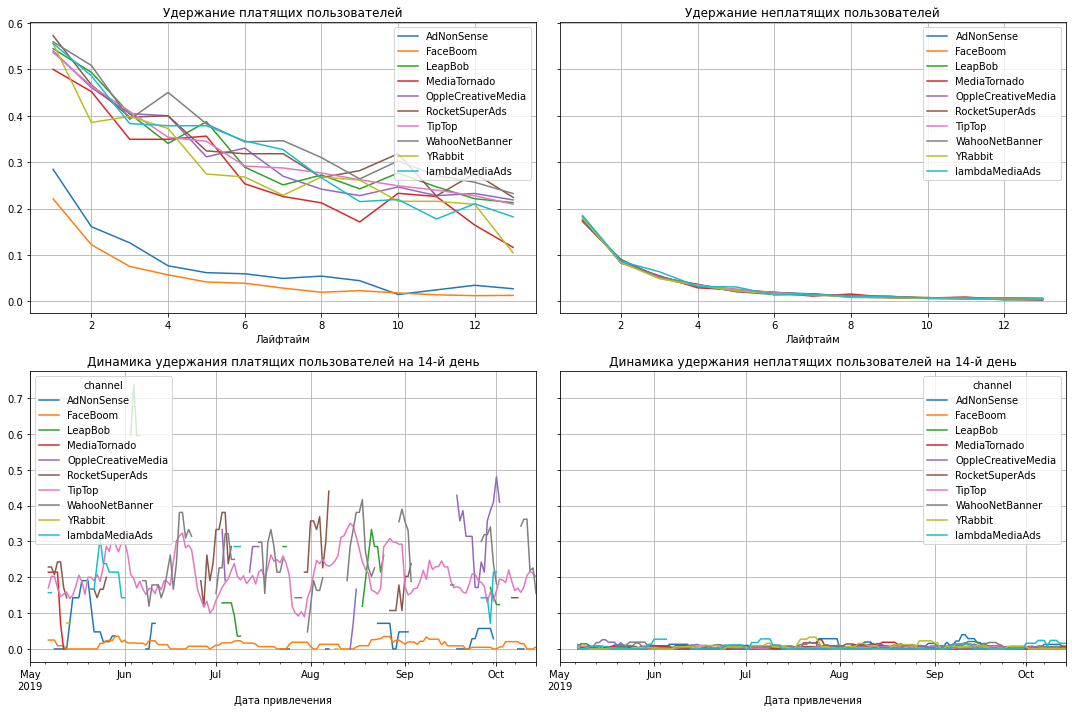

In [44]:
dimensions=['channel']

# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Не видим проблем с конверсией, а вот в графиках удержания видим, что плохо удерживаются пользователи из каналов FaceBoom и AdNonSense.

Ответим на поставленные вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 

**Ответ:** Стоимость привлечения одного клиента растёт. Значит сумма денег, в которую компании обходится каждый новый клиент увеличивается. Реклама не окупается.


- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

**Ответ:** Окупаемость не сильно зависит от устройств, но ее негативные показатели особенно заметны в США. Не окупаются пользователи, привлеченные из каналов AdNonSence, FaceBoom, TipTop. 


- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

**Ответ:** Вероятно, горизонт анализа выбран некорректно, но наиболее вероятно, что причина слабой окупаемости в нерациональном распределении средств на привлечение пользователей. Средства вкладываются в дорогие источники, не приносящие выгоды, самым простым примером выглядит канал TipTop, в котором стоимость за одного клиента еще и продолжает расти. Также стоит присмотреться к каналам AdNonSence и FaceBoom.

# Шаг 6. Напишите выводы

**6.1 Причины неэффективности привлечения пользователей**

Пользователи всех устройств окупались до середины июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

Основная аудитория - это пользователи из США, при этом стоимость привлечения пользователей из Америки - самая высокая, а окупаемость низкая. Окупаемость пользователей начала падать с середины июня 2019 года. 

Стоимость привлечения пользователей из рекламного канала TipTop слишком велика, а вот результата от этого дорогостоящего приобретия нет. Также не окупаются пользователи, привлеченные из каналов AdNonSense и FaceBoom. Причина неэффективности  - слишком большие затраты на привлечение клиентов из этих сетей (возникается вполне логичное предложение: пересмотреть количество пользователей, закупаемых у различных каналов и/или отказаться от части особо дорогостоящих).

**6.2 Рекомендации для отдела маркетинга для повышения эффективности**

Стоимость привлечения клиентов на устройствах Mac и iPhone выше, чем на PC и Andriod. Предлагается слделать выгодное предложение для держателей именно этих устройств, чтобы увеличить привлекательность приложения для клиентов.

Предлагается закупить больше аудитории из Великобритании и Германии,так как они окупаются лучше всего. Обязательно надо понять, что стало причиной снижения окупаемости пользователей в США с середины июня 2019 года (обновление, новый продукт, какое-то глобальное мировое событие?).

Стоимость привлечения пользователей из рекламного канала TipTop слишком высока и не дает почти никакого результата. Также не окупаются пользватели, привлеченные из каналов AdNonSence и FaceBoom. Стоит уменьшить средства, выделяемые на данные каналы привлечения и перераспредлить бюджет на покупку траффика у более дешевых, но прибыльных каналов, к примеру YRabbit, lambdaMediaAds и MediaTornado. У них высокая окупаемость, небольшая стоимость привлечения покупателя, а YRabbit уже показывал высокий ROI в июле. Причем предлагается направить усилия на привлечение пользователей из Европы, их окупаемость выше, чем из США.